In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns

rc('text', usetex=True)


# Utilities

In [2]:
import os
import yaml
from dnn_rem.rules.ruleset import Ruleset
import pandas as pd
import re

def load_experiment_results(experiment_dir):
    # Opens up the given experiment directory, loads all the serialized rule sets extracted for
    # each fold, and returns a list of them together with the config that generated those
    # rule sets
    with open(os.path.join(experiment_dir, 'config.yaml'), 'r') as file:
        config = yaml.safe_load(file)
    extractor_name = config.get('rule_extractor', 'REM-D')
    if extractor_name == "DeepRED":
        extractor_name = "DeepRED_C5"
    num_folds = config.get('n_folds', 5)
    extractor_dir = os.path.join(
        experiment_dir,
        f'cross_validation',
        f'{num_folds}_folds',
        f'rule_extraction',
        extractor_name,
    )
    rulesets_dir = os.path.join(extractor_dir, 'rules_extracted')
    rulesets = []
    if not os.path.isfile(os.path.join(extractor_dir, 'results.csv')):
        # Then we have not concluded this experiment so let's not trick ourselves
        return None
    for i in range(1, num_folds + 1):
        ruleset_file = os.path.join(rulesets_dir, f'fold_{i}.rules')
        if os.path.isfile(ruleset_file):
            ruleset = Ruleset()
            ruleset.from_file(ruleset_file)
            rulesets.append(ruleset)
    return config, pd.read_csv(os.path.join(extractor_dir, 'results.csv')), rulesets

def get_feature_distribution(rulesets):
    feature_counts = []
    global_feature_counts = []
    total_rule_num = 0
    for fold_ruleset in rulesets:
        feature_distribution = defaultdict(int)
        rule_count = 0
        for rule in fold_ruleset.rules:
            for clause in rule.premise:
                rule_count += 1
                used_terms = set()
                for term in clause.terms:
                    used_terms.add(term.variable)
                # We do this to make sure we only add each term at most
                # once per rule
                for term in used_terms:
                    feature_distribution[term] += 1
        feature_counts.append([
            100 * feature_distribution[f'feat_{i}']/rule_count
            for i in range(10)
        ])
        global_feature_counts.append([
            feature_distribution[f'feat_{i}']
            for i in range(10)
        ])
        total_rule_num += rule_count
    return feature_counts, 100 * np.sum(global_feature_counts, axis=0)/total_rule_num

def extract_results(directory, name_match=None):
    result = []
    if name_match is not None:
        regex = re.compile(name_match)
    else:
        regex = None
        
    for subdir_name in os.listdir(directory):
        if os.path.isfile(subdir_name):
            # Then we skip this guy for sure
            continue
        
        # Else let's check if it matches our given refular expression
        if (regex is not None) and (regex.fullmatch(subdir_name) is None):
            # Then time to continue our journey by ignoring this guy
            continue
        
        # Otherwise time to extract it and add it to our result
        subdir_path = os.path.join(directory, subdir_name)
        new_result = load_experiment_results(subdir_path)
        if new_result is not None:
            result.append((
                subdir_path,
                new_result
            ))
    return result


# Compression Experiment Plots

In [24]:
compression = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.95]
accuracies = [0.92, 0.916, 0.917, 0.923, 0.92, 0.902, 0.927, 0.93, 0.917, 0.913]
fidelity = [0.924, 0.928, 0.915, 0.93, 0.92, 0.911, 0.939, 0.942, 0.928, 0.92]
avg_num_rules = [1601.4, 356.6, 943.4, 85.8, 492.8, 96.6, 96.0, 231.8, 316.8, 139.6]
avg_rule_length = [5.358, 5.278, 4.82, 3.851, 5.447, 4.067, 4.176, 4.895, 5.773, 3.952]
extraction_time = [77.092, 72.447, 73.141, 58.331, 69.029, 67.378, 57.931, 71.611, 80.382, 64.635]
memory_taken = [4548.777, 898.166, 2641.323, 409.651, 2738.821, 1753.56, 1751.84, 688.949, 792.409, 539.393]

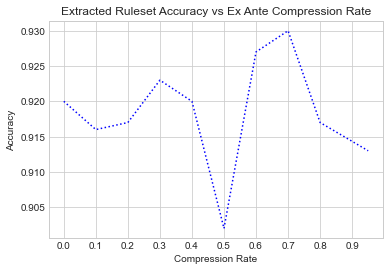

In [16]:
fig = plt.figure()
ax = plt.axes()
plt.ylabel("Accuracy")
plt.xlabel("Compression Rate")
plt.title("Extracted Ruleset Accuracy vs Ex Ante Compression Rate")
plt.xticks(np.arange(0, 1.1, 0.1))
ax.plot(compression, accuracies, ':b')

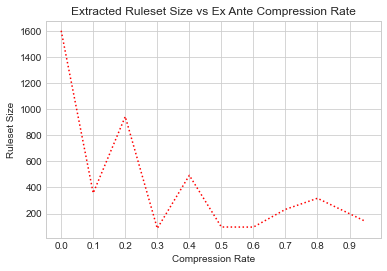

In [17]:
fig = plt.figure()
ax = plt.axes()
plt.ylabel("Ruleset Size")
plt.xlabel("Compression Rate")
plt.title("Extracted Ruleset Size vs Ex Ante Compression Rate")
plt.xticks(np.arange(0, 1.1, 0.1))
ax.plot(compression, avg_num_rules, ':r')

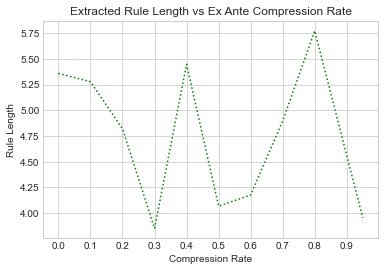

In [23]:
fig = plt.figure()
ax = plt.axes()
plt.ylabel("Rule Length")
plt.xlabel("Compression Rate")
plt.title("Extracted Rule Length vs Ex Ante Compression Rate")
plt.xticks(np.arange(0, 1.1, 0.1))
ax.plot(compression, avg_rule_length, ':g')

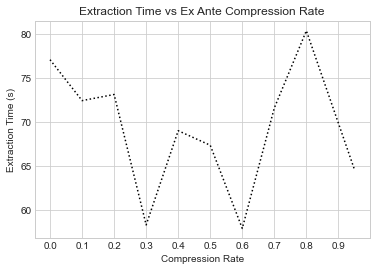

In [28]:
fig = plt.figure()
ax = plt.axes()
plt.ylabel("Extraction Time (s)")
plt.xlabel("Compression Rate")
plt.title("Extraction Time vs Ex Ante Compression Rate")
plt.xticks(np.arange(0, 1.1, 0.1))
ax.plot(compression, extraction_time, ':k')

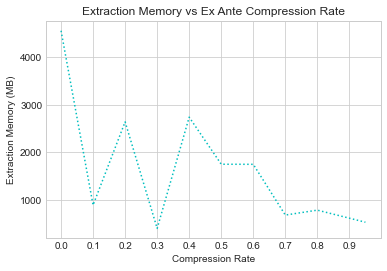

In [29]:
fig = plt.figure()
ax = plt.axes()
plt.ylabel("Extraction Memory (MB)")
plt.xlabel("Compression Rate")
plt.title("Extraction Memory vs Ex Ante Compression Rate")
plt.xticks(np.arange(0, 1.1, 0.1))
ax.plot(compression, memory_taken, ':c')

# Initial Data Sampling Experiment Plots

In [2]:
data_samples = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
aucs = [0.85, 0.855, 0.862, 0.857, 0.836, 0.866, 0.861, 0.86, 0.857, 0.856]
fidelity = [0.893, 0.889, 0.899, 0.893, 0.883, 0.901, 0.899, 0.899, 0.896, 0.898]
extraction_time = [105.702, 229.752, 330.098, 453.672, 553.069, 790.482, 816.987, 901.786, 1171.579, 1667.769]
memory_taken = [1692.958, 4832.63, 4265.109, 9086.223, 11221.316, 13368.431, 15487.649, 15988.793, 19733.824, 17631.655]
avg_num_rules = [90.8, 119.4, 98.6, 97.8, 95.2, 123.8, 114.0, 127.0, 105.2, 138.4]
var_num_rules = [35.824, 45.2, 45.421, 38.809, 38.154, 58.17, 47.447, 62.306, 36.706, 59.969]
avg_rule_length = [3.726, 3.836, 3.62, 3.746, 3.783, 3.917, 3.997, 3.928, 3.81, 4.205]


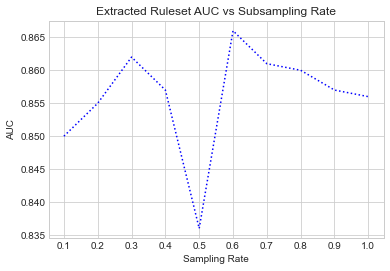

In [3]:
fig = plt.figure()
ax = plt.axes()
plt.ylabel("AUC")
plt.xlabel("Sampling Rate")
plt.title("Extracted Ruleset AUC vs Subsampling Rate")
plt.xticks(np.arange(0, 1.1, 0.1))
ax.plot(data_samples, aucs, ':b')

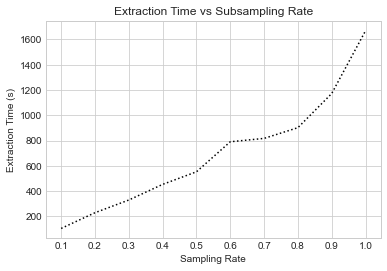

In [4]:
fig = plt.figure()
ax = plt.axes()
plt.ylabel("Extraction Time (s)")
plt.xlabel("Sampling Rate")
plt.title("Extraction Time vs Subsampling Rate")
plt.xticks(np.arange(0, 1.1, 0.1))
ax.plot(data_samples, extraction_time, ':k')

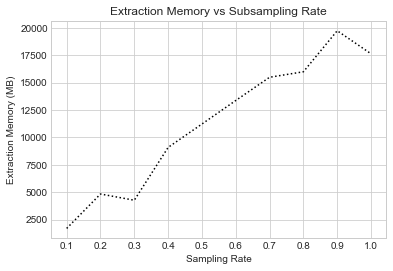

In [6]:
fig = plt.figure()
ax = plt.axes()
plt.ylabel("Extraction Memory (MB)")
plt.xlabel("Sampling Rate")
plt.title("Extraction Memory vs Subsampling Rate")
plt.xticks(np.arange(0, 1.1, 0.1))
ax.plot(data_samples, memory_taken, ':k')

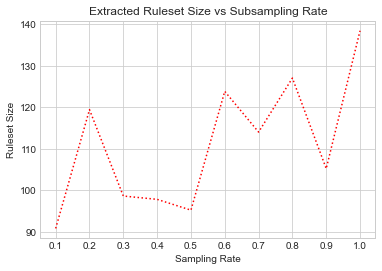

In [7]:
fig = plt.figure()
ax = plt.axes()
plt.ylabel("Ruleset Size")
plt.xlabel("Sampling Rate")
plt.title("Extracted Ruleset Size vs Subsampling Rate")
plt.xticks(np.arange(0, 1.1, 0.1))
ax.plot(data_samples, avg_num_rules, ':r')

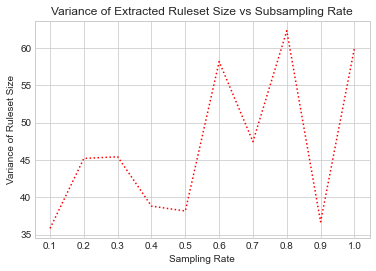

In [8]:
fig = plt.figure()
ax = plt.axes()
plt.ylabel("Variance of Ruleset Size")
plt.xlabel("Sampling Rate")
plt.title("Variance of Extracted Ruleset Size vs Subsampling Rate")
plt.xticks(np.arange(0, 1.1, 0.1))
ax.plot(data_samples, var_num_rules, ':r')

# Run-time Analysis Plots

## Profiler Results

In [4]:
stage_run_times = [
    ("substitute", 40, 237.718),
    ("C5.0", 238, 79.053),
    ("deleteRedundantTerms", 379213, 67.396),
    ("deleteUnsatisfiableRules", 1005, 12.565)
]
stage_run_times.sort(key=lambda x: -x[2])

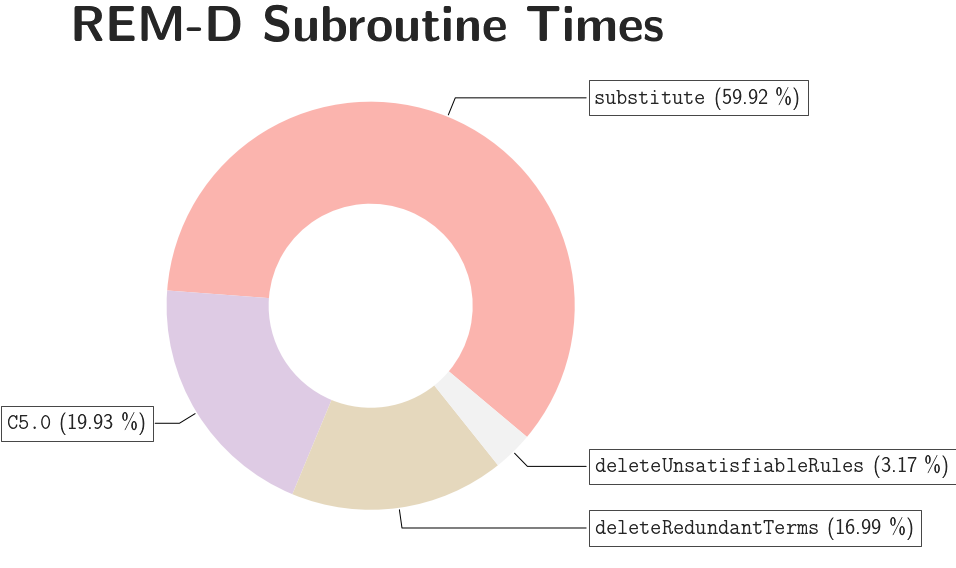

In [98]:
# Let's first make a pie chart showing how time is spent in substitution vs C5 and post processing
used_times = list(filter(lambda x: x[0] not in ["predict"], stage_run_times))
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw=dict(aspect="equal"))
total_time = sum(map(lambda x: x[-1], used_times))

data = list(map(lambda x: x[2], used_times))

wedges, texts = ax.pie(
    data,
    wedgeprops=dict(width=0.5),
    startangle=-40,
    colors=cm.Pastel1(np.linspace(0.0, 1.0, len(data))),
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(
    arrowprops=dict(arrowstyle="-"),
    bbox=bbox_props,
    zorder=0,
    va="center",
)

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(
        r"$\texttt{" + used_times[i][0] + f"}}$ ({100 * used_times[i][-1]/total_time:.2f} \%)",
        xy=(x, y),
        xytext=(1.1*np.sign(x), 1.1*y),
        horizontalalignment=horizontalalignment,
        fontsize=22,
        **kw
    )

ax.set_title(r"$\textbf{REM-D Subroutine Times}$", fontsize=50)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/rem_d_subroutine_times.png')
plt.show()


## Error Corruption Analysis

In [10]:
# One for each fold
intermediate_rulesets = [
    # For each fold and then for each intermediate layer:
    #     [acc, fid, num_clauses, num_terms, percent_removed_per_class]
    [
        [0.8825, 0.88375, 101, 39, (46.03, 39.64)],
        [0.825, 0.82625, 17, 20, (0, 0)],
        [0.90125, 0.9, 4, 6, (0, 0)],
        [0.9675, 0.96625, 3, 4, (0, 0)],
        [0.99875, 1.0, 2, 2, (0, 0)],
    ],
    [   
        [0.88375, 0.9025, 57, 40, (36.36, 0.0)],
        [0.815, 0.82375, 13, 14, (0, 0)],
        [0.90125, 0.9075, 5, 8, (0, 0)],
        [0.945, 0.95375, 3, 4, (0, 0)],
        [0.96875, 1.0, 2, 2, (0, 0)],
    ],
    [
        [0.84, 0.84, 17047, 180, (59.71, 90.63)],
        [0.75, 0.75, 276, 56, (7.69, 0)],
        [0.85625, 0.85375, 14, 18, (0, 0)],
        [0.9525, 0.9525, 3, 4, (0, 0)],
        [0.9975, 1.0, 2, 2, (0, 0)],
    ],
    [
        [0.9025, 0.9025, 583, 99, (37.45, 75.16)],
        [0.845, 0.845, 67, 43, (0, 0)],
        [0.89125, 0.89125, 17, 18, (0, 0)],
        [0.96625, 0.96625, 5, 7, (0, 0)],
        [1.0, 1.0, 2, 2, (0, 0)],
    ],
    [
        [0.855, 0.865, 53, 34, (36.11, 0.0)],
        [0.825, 0.8325, 12, 14, (0, 0)],
        [0.9275, 0.925, 6, 8, (0, 0)],
        [0.95625, 0.95875, 3, 4, (0, 0)],
        [0.9875, 1.0, 2, 2, (0, 0)],
    ],
]

[[ 88.25   82.5    90.125  96.75   99.875]
 [ 88.375  81.5    90.125  94.5    96.875]
 [ 84.     75.     85.625  95.25   99.75 ]
 [ 90.25   84.5    89.125  96.625 100.   ]
 [ 85.5    82.5    92.75   95.625  98.75 ]]
(5, 5)
[87.275 81.2   89.55  95.75  99.05 ]
[2.23103115 3.24961536 2.30162986 0.84779125 1.17420186]


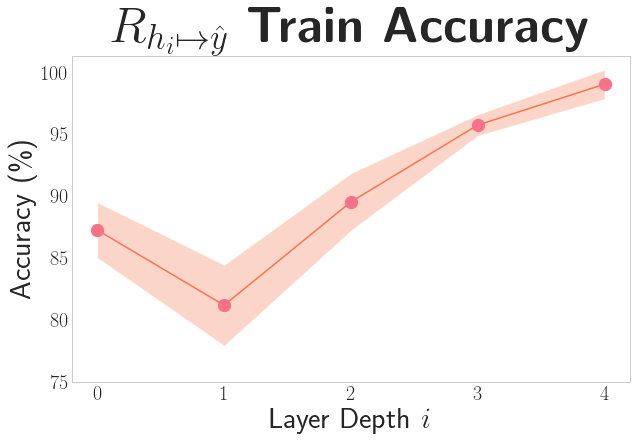

In [99]:
# Let's plot the accuracies of the intermediate rulesets
color_ind = 0
shade_ind = 1
intermediate_accs = np.array([
    [layer[0] * 100 for layer in fold]
    for fold in intermediate_rulesets
])
print(intermediate_accs)
print(intermediate_accs.shape)
intermediate_acc_means = np.mean(
    intermediate_accs,
    axis=0,
)

intermediate_acc_stds = np.std(
    intermediate_accs,
    axis=0,
)
print(intermediate_acc_means)
print(intermediate_acc_stds)


fig, ax = plt.subplots(figsize=(9, 6))#, subplot_kw=dict(aspect="equal"))
clrs = sns.color_palette("husl", 20)
with sns.axes_style("darkgrid"):
    layers = list(range(len(intermediate_acc_means)))
    ax.plot(
        layers,
        intermediate_acc_means,
        label="Test Accuracy",
        c=clrs[shade_ind],
        zorder=1,
    )
    plt.scatter(layers, intermediate_acc_means,s=150,color=clrs[color_ind], zorder=2)
    ax.fill_between(
        layers,
        intermediate_acc_means - intermediate_acc_stds,
        intermediate_acc_means + intermediate_acc_stds,
        alpha=0.3,
        facecolor=clrs[shade_ind],
    )
#     ax.legend()

plt.ylabel("Accuracy (\%)", fontsize=30)
plt.xlabel("Layer Depth $i$", fontsize=30)
plt.title(r"$ R_{h_i \mapsto \hat{y}} \textbf{ Train Accuracy}$", fontsize=50)
plt.xticks(layers, fontsize=20)
plt.yticks(list(np.arange(75, 100, 5)) + [100], fontsize=20)
ax.grid(False)
plt.savefig('../Dissertation/Figures/Chapter_3/rem_d_intermediate_accuracy.png')
plt.show()

[[ 88.375  82.625  90.     96.625 100.   ]
 [ 90.25   82.375  90.75   95.375 100.   ]
 [ 84.     75.     85.375  95.25  100.   ]
 [ 90.25   84.5    89.125  96.625 100.   ]
 [ 86.5    83.25   92.5    95.875 100.   ]]
[ 87.875  81.55   89.55   95.95  100.   ]
[2.384848   3.3565235  2.36458242 0.58949131 0.        ]


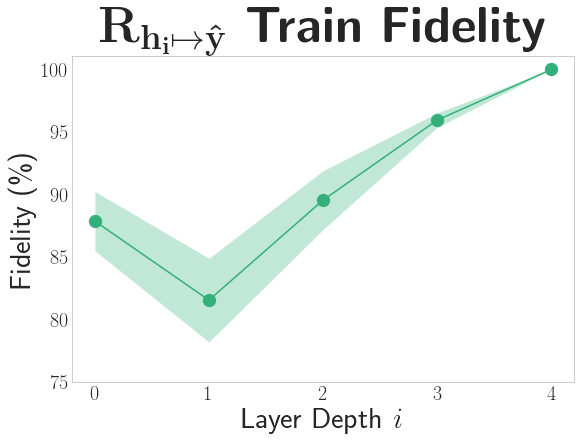

In [19]:
# Let's plot the fidelity of the intermediate rulesets
color_ind = 8
shade_ind = 8
intermediate_fids = np.array([
    [layer[1] * 100 for layer in fold]
    for fold in intermediate_rulesets
])
print(intermediate_fids)
intermediate_fid_means = np.mean(
    intermediate_fids,
    axis=0,
)

intermediate_fid_stds = np.std(
    intermediate_fids,
    axis=0,
)
print(intermediate_fid_means)
print(intermediate_fid_stds)


fig, ax = plt.subplots(figsize=(9, 6))#, subplot_kw=dict(aspect="equal"))
clrs = sns.color_palette("husl", 20)

with sns.axes_style("darkgrid"):
    layers = list(range(len(intermediate_fid_means)))
    ax.plot(
        layers,
        intermediate_fid_means,
        label="Test Fidelity",
        c=clrs[shade_ind],
        zorder=1,
    )
    plt.scatter(layers, intermediate_fid_means, s=150, color=clrs[color_ind], zorder=2)
    ax.fill_between(
        layers,
        intermediate_fid_means - intermediate_fid_stds,
        intermediate_fid_means + intermediate_fid_stds,
        alpha=0.3,
        facecolor=clrs[shade_ind],
    )
#     ax.legend()

plt.ylabel("Fidelity (\%)", fontsize=30)
plt.xlabel("Layer Depth $i$", fontsize=30)
plt.title(r"$\mathbf{R_{h_i \mapsto \hat{y}}} \textbf{ Train Fidelity}$", fontsize=50)
plt.xticks(layers, fontsize=20)
plt.yticks(list(np.arange(75, 100, 5)) + [100], fontsize=20)
ax.grid(False)
plt.savefig('../Dissertation/Figures/Chapter_3/rem_d_intermediate_fidelity.png')
plt.show()

[[  101    17     4     3     2]
 [   57    13     5     3     2]
 [17047   276    14     3     2]
 [  583    67    17     5     2]
 [   53    12     6     3     2]]
[3.5682e+03 7.7000e+01 9.2000e+00 3.4000e+00 2.0000e+00]
[6.74234530e+03 1.01609055e+02 5.26877595e+00 8.00000000e-01
 0.00000000e+00]


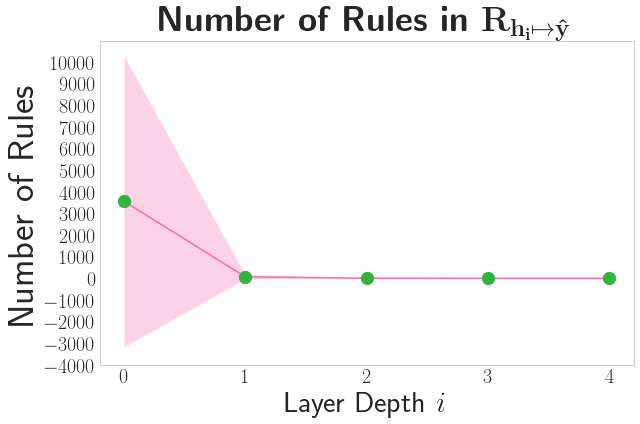

In [106]:
# Let's plot the number of rules in intermediate rulesets
color_ind = 7
shade_ind = 19
intermediate_clauses = np.array([
    [layer[2] for layer in fold]
    for fold in intermediate_rulesets
])
print(intermediate_clauses)
intermediate_clauses_means = np.mean(
    intermediate_clauses,
    axis=0,
)

intermediate_clauses_stds = np.std(
    intermediate_clauses,
    axis=0,
)
print(intermediate_clauses_means)
print(intermediate_clauses_stds)


fig, ax = plt.subplots(figsize=(9, 6))#, subplot_kw=dict(aspect="equal"))
clrs = sns.color_palette("husl", max(color_ind, shade_ind) + 1)
with sns.axes_style("darkgrid"):
    layers = list(range(len(intermediate_clauses_means)))
    ax.plot(
        layers,
        intermediate_clauses_means,
        label="Number of Rules",
        c=clrs[shade_ind],
        zorder=1,
    )
    plt.scatter(layers, intermediate_clauses_means, s=150, color=clrs[color_ind], zorder=2)
    ax.fill_between(
        layers,
        intermediate_clauses_means - intermediate_clauses_stds,
        intermediate_clauses_means + intermediate_clauses_stds,
        alpha=0.3,
        facecolor=clrs[shade_ind],
    )
#     ax.legend()

plt.ylabel("Number of Rules", fontsize=37)
plt.xlabel("Layer Depth $i$", fontsize=30)
plt.title(r"$\textbf{Number of Rules in } \mathbf{R_{h_i \mapsto \hat{y}}}$", fontsize=35)
plt.xticks(layers, fontsize=20)
plt.yticks(
    list(range(
        -4000,
        int(max(intermediate_clauses_means + intermediate_clauses_stds)) + 500,
        1000
    )),
    fontsize=20,
)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/rem_d_intermediate_clauses.png')
plt.show()

[[ 39  20   6   4   2]
 [ 40  14   8   4   2]
 [180  56  18   4   2]
 [ 99  43  18   7   2]
 [ 34  14   8   4   2]]
[78.4 29.4 11.6  4.6  2. ]
[56.11630779 17.05989449  5.27636238  1.2         0.        ]


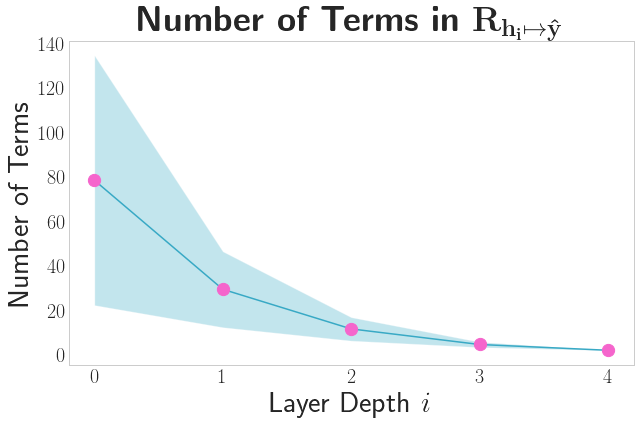

In [105]:
# Let's plot the number of terms in intermediate rulesets
color_ind = 9
shade_ind = 6
intermediate_terms = np.array([
    [layer[3] for layer in fold]
    for fold in intermediate_rulesets
])
print(intermediate_terms)
intermediate_terms_means = np.mean(
    intermediate_terms,
    axis=0,
)

intermediate_terms_stds = np.std(
    intermediate_terms,
    axis=0,
)
print(intermediate_terms_means)
print(intermediate_terms_stds)


fig, ax = plt.subplots(figsize=(9, 6))#, subplot_kw=dict(aspect="equal"))
clrs = sns.color_palette("husl", max(color_ind, shade_ind) + 1)
with sns.axes_style("darkgrid"):
    layers = list(range(len(intermediate_terms_means)))
    ax.plot(
        layers,
        intermediate_terms_means,
        label="Number of Terms",
        c=clrs[shade_ind],
        zorder=1,
    )
    plt.scatter(layers, intermediate_terms_means, s=150, color=clrs[color_ind], zorder=2)
    ax.fill_between(
        layers,
        intermediate_terms_means - intermediate_terms_stds,
        intermediate_terms_means + intermediate_terms_stds,
        alpha=0.3,
        facecolor=clrs[shade_ind],
    )
#     ax.legend()

plt.ylabel("Number of Terms", fontsize=30)
plt.xlabel("Layer Depth $i$", fontsize=30)
plt.title(r"$\textbf{Number of Terms in } \mathbf{R_{h_i \mapsto \hat{y}}}$", fontsize=35)
plt.xticks(layers, fontsize=20)
plt.yticks(
    list(range(0, int(max(intermediate_terms_means + intermediate_terms_stds)) + 20, 20)),
    fontsize=20,
)
# plt.yscale('log')
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/rem_d_intermediate_terms.png')
plt.show()

[[46.03  0.    0.    0.    0.  ]
 [36.36  0.    0.    0.    0.  ]
 [59.71  7.69  0.    0.    0.  ]
 [37.45  0.    0.    0.    0.  ]
 [36.11  0.    0.    0.    0.  ]]
[43.132  1.538  0.     0.     0.   ]
[9.06291432 3.076      0.         0.         0.        ]
[[39.64  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [90.63  0.    0.    0.    0.  ]
 [75.16  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[41.086  0.     0.     0.     0.   ]
[37.40014738  0.          0.          0.          0.        ]


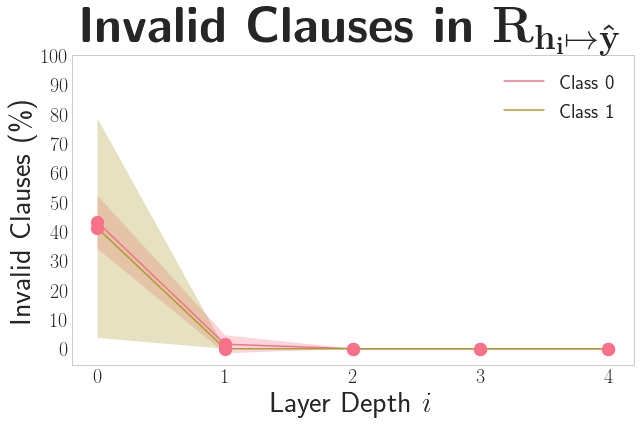

In [107]:
# Let's plot the number of terms in intermediate rulesets
fig, ax = plt.subplots(figsize=(9, 6))#, subplot_kw=dict(aspect="equal"))
for class_id in range(2):
    intermediate_invalid = np.array([
        [layer[4][class_id] for layer in fold]
        for fold in intermediate_rulesets
    ])
    print(intermediate_invalid)
    intermediate_invalid_means = np.mean(
        intermediate_invalid,
        axis=0,
    )

    intermediate_invalid_stds = np.std(
        intermediate_invalid,
        axis=0,
    )
    print(intermediate_invalid_means)
    print(intermediate_invalid_stds)


    clrs = sns.color_palette("husl", 5)
    layers = list(range(len(intermediate_invalid_means)))
    ax.plot(
        layers,
        intermediate_invalid_means,
        label=f"Class {class_id}",
        c=clrs[class_id],
        zorder=1,
    )
    plt.scatter(layers, intermediate_invalid_means, s=150, color=clrs[0], zorder=2)
    ax.fill_between(
        layers,
        intermediate_invalid_means - intermediate_invalid_stds,
        intermediate_invalid_means + intermediate_invalid_stds,
        alpha=0.3,
        facecolor=clrs[class_id],
    )
ax.legend(prop={"size":20})
plt.ylabel("Invalid Clauses (\%)", fontsize=30)
plt.xlabel("Layer Depth $i$", fontsize=30)
plt.title(r"$\textbf{Invalid Clauses in } \mathbf{R_{h_i \mapsto \hat{y}}}$", fontsize=50)
plt.xticks(layers, fontsize=20)
plt.yticks(list(range(0, 110, 10)), fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/rem_d_invalid_clauses.png')

plt.show()

[[46.03  0.    0.    0.    0.  ]
 [36.36  0.    0.    0.    0.  ]
 [59.71  7.69  0.    0.    0.  ]
 [37.45  0.    0.    0.    0.  ]
 [36.11  0.    0.    0.    0.  ]]
[43.132  1.538  0.     0.     0.   ]
[9.06291432 3.076      0.         0.         0.        ]
[[39.64  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [90.63  0.    0.    0.    0.  ]
 [75.16  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[41.086  0.     0.     0.     0.   ]
[37.40014738  0.          0.          0.          0.        ]


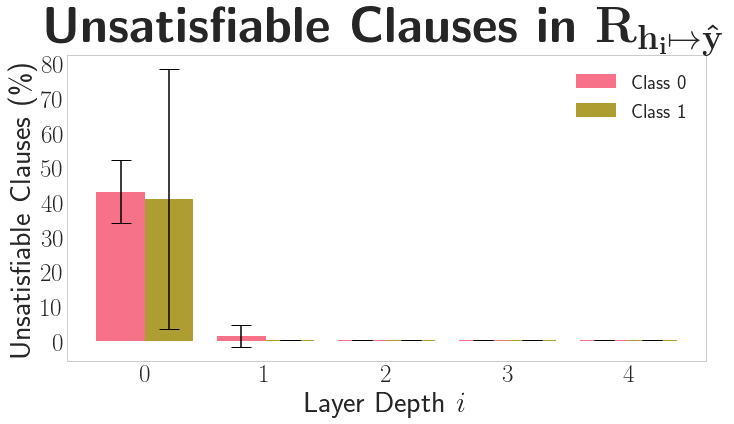

In [108]:
# Let's plot the number of terms in intermediate rulesets
fig, ax = plt.subplots(figsize=(10, 6))#, subplot_kw=dict(aspect="equal"))
for class_id in range(2):
    intermediate_invalid = np.array([
        [layer[4][class_id] for layer in fold]
        for fold in intermediate_rulesets
    ])
    print(intermediate_invalid)
    intermediate_invalid_means = np.mean(
        intermediate_invalid,
        axis=0,
    )

    intermediate_invalid_stds = np.std(
        intermediate_invalid,
        axis=0,
    )
    print(intermediate_invalid_means)
    print(intermediate_invalid_stds)

    clrs = sns.color_palette("husl", 5)
    layers = np.array(list(range(len(intermediate_invalid_means))))
    ax.bar(
        layers - 0.2 + 0.4 * class_id,
        np.maximum(intermediate_invalid_means, 0.5),
        width=0.4,
        color=clrs[class_id],
        align='center',
        label=f"Class {class_id}",
        yerr=intermediate_invalid_stds,
        capsize=10,
    )

ax.legend(prop={"size":20})
plt.ylabel("Unsatisfiable Clauses (\%)", fontsize=30)
plt.xlabel("Layer Depth $i$", fontsize=30)
plt.title(r"$\textbf{Unsatisfiable Clauses in } \mathbf{R_{h_i \mapsto \hat{y}}}$", fontsize=50)
plt.xticks(layers, fontsize=25)
plt.yticks(list(range(0, 90, 10)), fontsize=25)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/rem_d_invalid_clauses.png')

plt.show()

# XOR Analysis

In [32]:
# First load up the best results we obtained for both REM-D and ECLAIRE
XOR_ECLAIRE_RESULTS_DIR = "../results/XOR/erem_d_min_cases_2_best"
XOR_REM_D_RESULTS_DIR = "../results/XOR/baseline_rem_d_min_cases_33_best"
XOR_DEEP_RED_RESULTS_DIR = "../results/XOR/baseline_deep_red_min_cases_30_best"

xor_eclaire_config, xor_eclaire_results, xor_eclaire_rulesets = load_experiment_results(XOR_ECLAIRE_RESULTS_DIR)
xor_rem_d_config, xor_rem_d_results, xor_rem_d_rulesets = load_experiment_results(XOR_REM_D_RESULTS_DIR)
xor_deep_red_config, xor_deep_red_results, xor_deep_red_rulesets = load_experiment_results(XOR_DEEP_RED_RESULTS_DIR)

In [33]:
from collections import defaultdict

# Now let's look at all of the rules in all of the folds and see how much each feature is used
# for both of these methods
feature_counts_eclaire, feature_counts_eclaire_global = get_feature_distribution(xor_eclaire_rulesets)
feature_counts_eclaire_means = np.mean(feature_counts_eclaire, axis=0)
feature_counts_eclaire_stds = np.std(feature_counts_eclaire, axis=0)

feature_counts_rem_d, feature_counts_rem_d_global = get_feature_distribution(xor_rem_d_rulesets)
feature_counts_rem_d_means = np.mean(feature_counts_rem_d, axis=0)
feature_counts_rem_d_stds = np.std(feature_counts_rem_d, axis=0)

feature_counts_deep_red, feature_counts_deep_red_global = get_feature_distribution(xor_deep_red_rulesets)
feature_counts_deep_red_means = np.mean(feature_counts_deep_red, axis=0)
feature_counts_deep_red_stds = np.std(feature_counts_deep_red, axis=0)


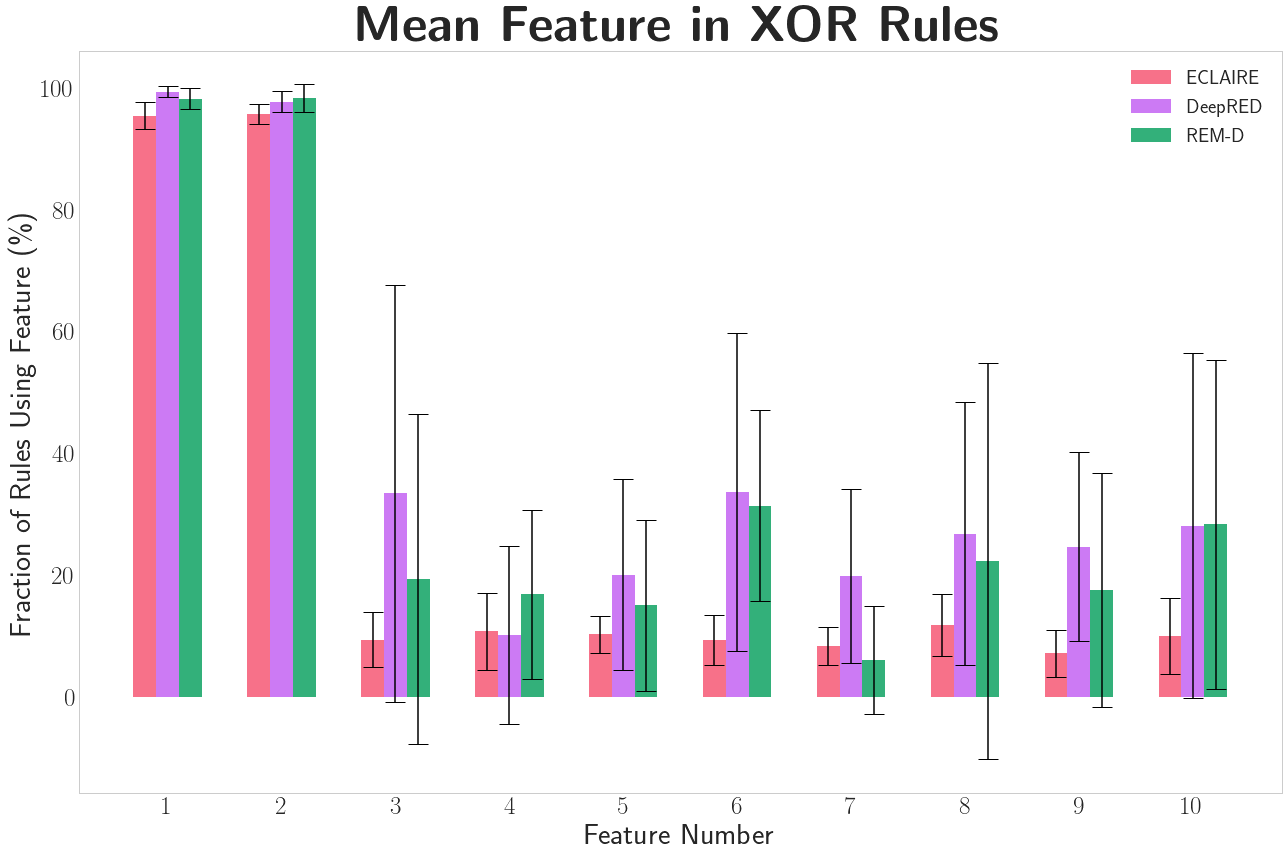

In [109]:
fig, ax = plt.subplots(figsize=(18, 12))#, subplot_kw=dict(aspect="equal"))
clrs = sns.color_palette("husl", 5)
features = np.array(list(range(1, 11)))
ax.bar(
    features - 0.2,
    feature_counts_eclaire_means,
    width=0.2,
    color=clrs[0],
    align='center',
    label=f"ECLAIRE",
    yerr=feature_counts_eclaire_stds,
    capsize=10,
)

ax.bar(
    features,
    feature_counts_deep_red_means,
    width=0.2,
    color=clrs[4],
    align='center',
    label=f"DeepRED",
    yerr=feature_counts_deep_red_stds,
    capsize=10,
)

ax.bar(
    features + 0.2,
    feature_counts_rem_d_means,
    width=0.2,
    color=clrs[2],
    align='center',
    label=f"REM-D",
    yerr=feature_counts_rem_d_stds,
    capsize=10,
)

ax.legend(prop={"size":20})
plt.ylabel("Fraction of Rules Using Feature (\%)", fontsize=30)
plt.xlabel("Feature Number", fontsize=30)
plt.title(r"$\textbf{Mean Feature in XOR Rules}$", fontsize=50)
plt.xticks(features, fontsize=25)
plt.yticks(fontsize=25)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/xor_experiment_mean_distribution.png')

plt.show()

[95.63218391 95.86206897 10.11494253 11.49425287 10.11494253  9.65517241
  8.73563218 12.4137931   7.5862069  10.8045977 ]


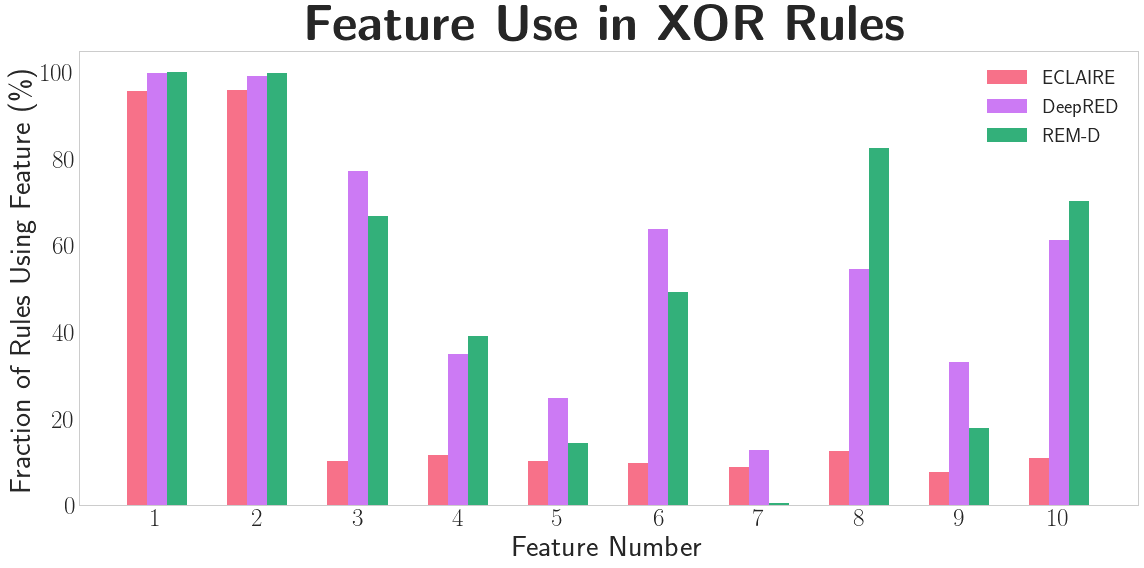

In [110]:
fig, ax = plt.subplots(figsize=(16, 8))#, subplot_kw=dict(aspect="equal"))
clrs = sns.color_palette("husl", 5)
features = np.array(list(range(1, 11)))
print(feature_counts_eclaire_global)
ax.bar(
    features - 0.2,
    feature_counts_eclaire_global,
    width=0.2,
    color=clrs[0],
    align='center',
    label=f"ECLAIRE",
)

ax.bar(
    features,
    feature_counts_deep_red_global,
    width=0.2,
    color=clrs[4],
    align='center',
    label=f"DeepRED",
)

ax.bar(
    features + 0.2,
    feature_counts_rem_d_global,
    width=0.2,
    color=clrs[2],
    align='center',
    label=f"REM-D",
)

ax.legend(prop={"size":20})
plt.ylabel("Fraction of Rules Using Feature (\%)", fontsize=30)
plt.xlabel("Feature Number", fontsize=30)
plt.title(r"$\textbf{Feature Use in XOR Rules}$", fontsize=50)
plt.xticks(features, fontsize=25)
plt.yticks(fontsize=25)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/xor_experiment_distribution.png')

plt.show()

# MAGIC min cases Ablation Study

In [46]:
# First let's extract the accuracies, rule sizes, and run times of all of our MAGIC experiments
magic_min_cases_results = extract_results('../results/MAGIC//three_layers', 'erem_d_min_cases_[0-9]+')
magic_min_cases_results.sort(key=lambda x: x[1][0]['extractor_params']['min_cases'])
magic_ablation_min_cases = list(map(lambda x: x[1][0]['extractor_params']['min_cases'], magic_min_cases_results))
print(magic_ablation_min_cases)
magic_ablation_accuracies = list(map(lambda x: (np.mean(x[1][1]['re_acc']), np.std(x[1][1]['re_acc'])), magic_min_cases_results))
magic_ablation_fidelities = list(map(lambda x: (np.mean(x[1][1]['re_fid']), np.std(x[1][1]['re_fid'])), magic_min_cases_results))
def _ruleset_sizes(rulesets):
    return list(map(
        lambda x: x.num_clauses(),
        rulesets
    ))

magic_ablation_rule_sizes = list(map(
    lambda x: (np.mean(_ruleset_sizes(x[1][2])), np.std(_ruleset_sizes(x[1][2]))),
    magic_min_cases_results
))
magic_ablation_runtimes = list(map(lambda x: (np.mean(x[1][1]['re_time (sec)']), np.std(x[1][1]['re_time (sec)'])), magic_min_cases_results))


[30, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400]


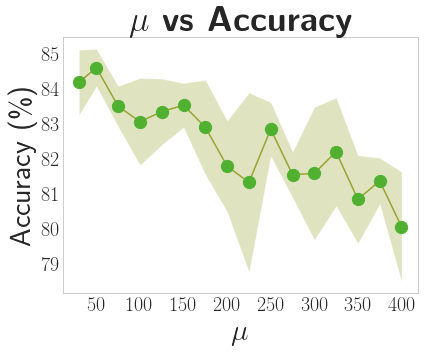

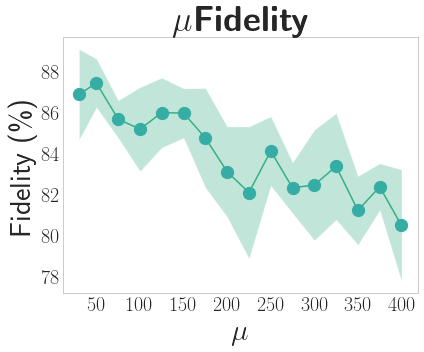

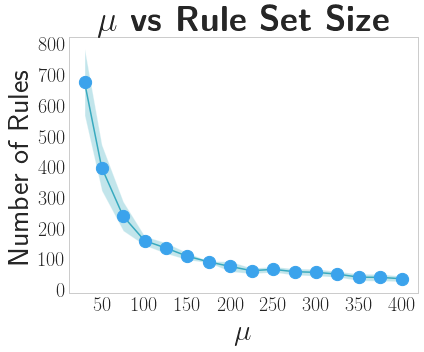

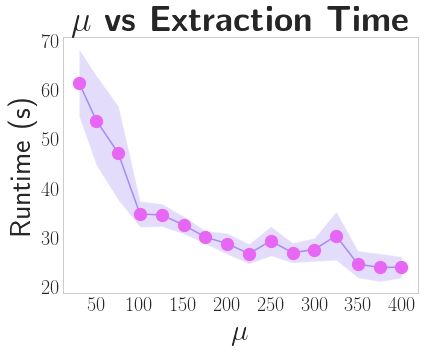

In [111]:
# Now use it to visualize the accuracy as a function of the number of min cases
fig, ax = plt.subplots(figsize=(6, 5))
clrs = sns.color_palette("husl", 12)
means = np.array(list(map(lambda x: x[0], magic_ablation_accuracies))) * 100
stds = np.array(list(map(lambda x: x[1], magic_ablation_accuracies))) * 100
with sns.axes_style("darkgrid"):
    ax.plot(
        magic_ablation_min_cases,
        means,
        label="Accuracy",
        c=clrs[3],
        zorder=1,
    )
    plt.scatter(magic_ablation_min_cases, means, s=150, color=clrs[4], zorder=2)
    ax.fill_between(
        magic_ablation_min_cases,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[3],
    )

# ax.legend(prop={"size":20})
plt.xlabel("$$ \mu $$", fontsize=30)
plt.ylabel("Accuracy (\%)", fontsize=30)
plt.title(r"$\mathbf{\mu} \textbf{ vs Accuracy}$", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_magic_min_cases_ablation_accuracy.png')
plt.show()


# Time to look at fidelity
fig, ax = plt.subplots(figsize=(6, 5))
means = np.array(list(map(lambda x: x[0], magic_ablation_fidelities))) * 100
stds = np.array(list(map(lambda x: x[1], magic_ablation_fidelities))) * 100
with sns.axes_style("darkgrid"):
    ax.plot(
        magic_ablation_min_cases,
        means,
        label="Fidelity",
        c=clrs[5],
        zorder=1,
    )
    plt.scatter(magic_ablation_min_cases, means, s=150, color=clrs[6], zorder=2)
    ax.fill_between(
        magic_ablation_min_cases,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[5],
    )

# ax.legend(prop={"size":20})
plt.xlabel("$$ \mu $$", fontsize=30)
plt.ylabel("Fidelity (\%)", fontsize=30)
plt.title(r"$\mathbf{\mu} \textbf{Fidelity}$", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_magic_min_cases_ablation_fidelity.png')
plt.show()



# Rule set sizes
fig, ax = plt.subplots(figsize=(6, 5))
means = np.array(list(map(lambda x: x[0], magic_ablation_rule_sizes)))
stds = np.array(list(map(lambda x: x[1], magic_ablation_rule_sizes)))
with sns.axes_style("darkgrid"):
    ax.plot(
        magic_ablation_min_cases,
        means,
        label="Number of Rules",
        c=clrs[7],
        zorder=1,
    )
    plt.scatter(magic_ablation_min_cases, means, s=150, color=clrs[8], zorder=2)
    ax.fill_between(
        magic_ablation_min_cases,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[7],
    )

# ax.legend(prop={"size":20})
plt.xlabel("$$ \mu $$", fontsize=30)
plt.ylabel("Number of Rules", fontsize=30)
plt.title(r"$\mathbf{\mu} \textbf{ vs Rule Set Size}$", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_magic_min_cases_ablation_ruleset_size.png')
plt.show()


# Run times
fig, ax = plt.subplots(figsize=(6, 5))
means = np.array(list(map(lambda x: x[0], magic_ablation_runtimes)))
stds = np.array(list(map(lambda x: x[1], magic_ablation_runtimes)))
with sns.axes_style("darkgrid"):
    ax.plot(
        magic_ablation_min_cases,
        means,
        label="Runtime",
        c=clrs[9],
        zorder=1,
    )
    plt.scatter(magic_ablation_min_cases, means, s=150, color=clrs[10], zorder=2)
    ax.fill_between(
        magic_ablation_min_cases,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[9],
    )

# ax.legend(prop={"size":20})
plt.xlabel("$$ \mu $$", fontsize=30)
plt.ylabel("Runtime (s)", fontsize=30)
plt.title(r"$\mathbf{\mu} \textbf{ vs Extraction Time}$", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_magic_min_cases_ablation_runtime.png')
plt.show()

# MiniBooNE min cases Ablation Study

In [49]:
# First let's extract the accuracies, rule sizes, and run times of all of our MAGIC experiments
miniboone_min_cases_results = extract_results('../results/MiniBooNE/medium_performance_study', 'erem_d_min_cases.*')
def _miniboone_filter(config, max_min_cases=1):
    extractor_params = config['extractor_params']
    min_cases = extractor_params['min_cases']
    if min_cases >= max_min_cases:
        return False
    if min_cases != (extractor_params.get('initial_min_cases', min_cases) or min_cases):
        return False
    if min_cases != (extractor_params.get('intermediate_end_min_cases', min_cases) or min_cases):
        return False
    if (extractor_params.get('block_size', 1) or 1) != 1:
        return False
    if (extractor_params.get('max_number_of_samples', 0) or 1) != 1:
        return False
    return True
miniboone_min_cases_results = list(filter(lambda x: _miniboone_filter(x[1][0], 0.03), miniboone_min_cases_results))

miniboone_min_cases_results.sort(key=lambda x: x[1][0]['extractor_params']['min_cases'])
miniboone_ablation_min_cases = list(map(lambda x: x[1][0]['extractor_params']['min_cases'] * 100, miniboone_min_cases_results))
print(miniboone_ablation_min_cases)
miniboone_ablation_accuracies = list(map(lambda x: (np.mean(x[1][1]['re_acc']), np.std(x[1][1]['re_acc'])), miniboone_min_cases_results))
miniboone_ablation_fidelities = list(map(lambda x: (np.mean(x[1][1]['re_fid']), np.std(x[1][1]['re_fid'])), miniboone_min_cases_results))
def _ruleset_sizes(rulesets):
    return list(map(
        lambda x: x.num_clauses(),
        rulesets
    ))

miniboone_ablation_rule_sizes = list(map(
    lambda x: (np.mean(_ruleset_sizes(x[1][2])), np.std(_ruleset_sizes(x[1][2]))),
    miniboone_min_cases_results
))
miniboone_ablation_runtimes = list(map(lambda x: (np.mean(x[1][1]['re_time (sec)']), np.std(x[1][1]['re_time (sec)'])), miniboone_min_cases_results))


[0.08, 0.1, 0.3, 0.5, 0.7000000000000001, 0.8999999999999999, 1.0, 1.2, 1.5, 1.7000000000000002, 2.0]


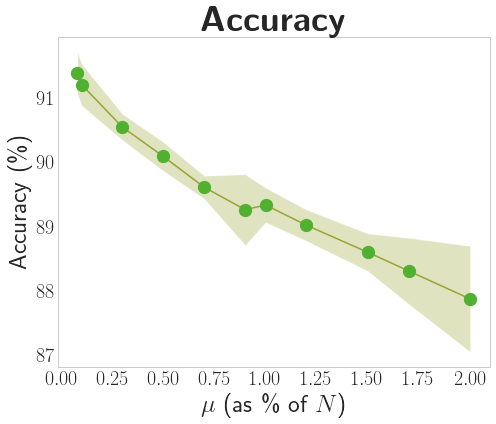

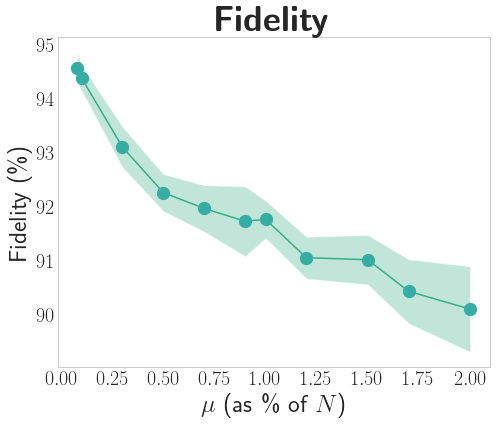

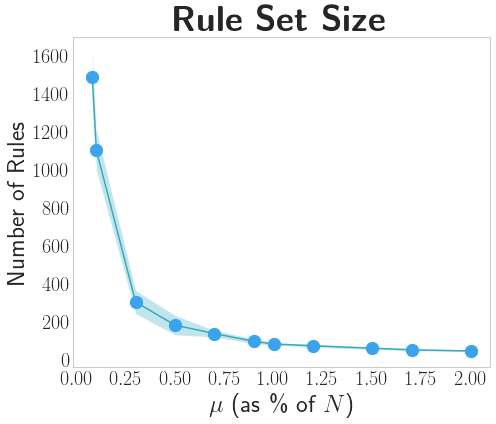

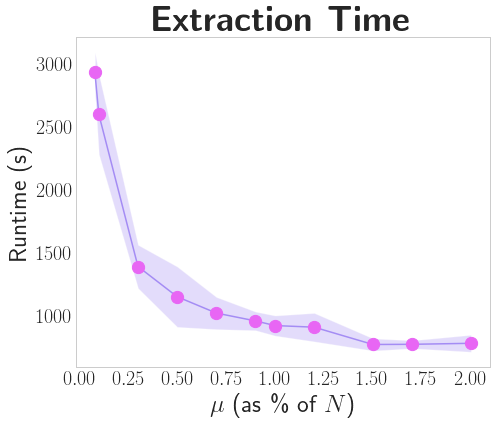

In [112]:
# Same as above but this time with MiniBooNE
fig, ax = plt.subplots(figsize=(7, 6))
clrs = sns.color_palette("husl", 12)
means = np.array(list(map(lambda x: x[0], miniboone_ablation_accuracies))) * 100
stds = np.array(list(map(lambda x: x[1], miniboone_ablation_accuracies))) * 100
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_ablation_min_cases,
        means,
        label="Accuracy",
        c=clrs[3],
        zorder=1,
    )
    plt.scatter(miniboone_ablation_min_cases, means, s=150, color=clrs[4], zorder=2)
    ax.fill_between(
        miniboone_ablation_min_cases,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[3],
    )

# ax.legend(prop={"size":20})
plt.xlabel("$ \mu $ (as \% of $N$)", fontsize=25)
plt.ylabel("Accuracy (\%)", fontsize=25)
plt.title(r"$\textbf{Accuracy}$", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_min_cases_ablation_accuracy.png')
plt.show()


# Time to look at fidelity
fig, ax = plt.subplots(figsize=(7, 6))
means = np.array(list(map(lambda x: x[0], miniboone_ablation_fidelities))) * 100
stds = np.array(list(map(lambda x: x[1], miniboone_ablation_fidelities))) * 100
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_ablation_min_cases,
        means,
        label="Fidelity",
        c=clrs[5],
        zorder=1,
    )
    plt.scatter(miniboone_ablation_min_cases, means, s=150, color=clrs[6], zorder=2)
    ax.fill_between(
        miniboone_ablation_min_cases,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[5],
    )

# ax.legend(prop={"size":20})
plt.xlabel("$ \mu $ (as \% of $N$)", fontsize=25)
plt.ylabel("Fidelity (\%)", fontsize=25)
plt.title(r"$\textbf{Fidelity}$", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_min_cases_ablation_fidelity.png')
plt.show()



# Rule set sizes
fig, ax = plt.subplots(figsize=(7, 6))
means = np.array(list(map(lambda x: x[0], miniboone_ablation_rule_sizes)))
stds = np.array(list(map(lambda x: x[1], miniboone_ablation_rule_sizes)))
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_ablation_min_cases,
        means,
        label="Number of Rules",
        c=clrs[7],
        zorder=1,
    )
    plt.scatter(miniboone_ablation_min_cases, means, s=150, color=clrs[8], zorder=2)
    ax.fill_between(
        miniboone_ablation_min_cases,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[7],
    )

# ax.legend(prop={"size":20})
plt.xlabel("$ \mu $ (as \% of $N$)", fontsize=25)
plt.ylabel("Number of Rules", fontsize=25)
plt.title(r"$\textbf{Rule Set Size}$", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_min_cases_ablation_ruleset_size.png')
plt.show()


# Run times
fig, ax = plt.subplots(figsize=(7, 6))
means = np.array(list(map(lambda x: x[0], miniboone_ablation_runtimes)))
stds = np.array(list(map(lambda x: x[1], miniboone_ablation_runtimes)))
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_ablation_min_cases,
        means,
        label="Runtime",
        c=clrs[9],
        zorder=1,
    )
    plt.scatter(miniboone_ablation_min_cases, means, s=150, color=clrs[10], zorder=2)
    ax.fill_between(
        miniboone_ablation_min_cases,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[9],
    )

# ax.legend(prop={"size":20})
plt.xlabel("$ \mu $ (as \% of $N$)", fontsize=25)
plt.ylabel("Runtime (s)", fontsize=25)
plt.title(r"$\textbf{Extraction Time}$", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_min_cases_ablation_runtime.png')
plt.show()

# Layer Subsampling for MiniBooNE experiment

In [60]:
# First let's extract the accuracies, rule sizes, and run times of all of our MAGIC experiments
miniboone_block_sizes_results = extract_results(
    '../results/MiniBooNE/medium_performance_study',
    'erem_d_min_cases_0.001_intermediate_min_cases_0.001_max_samples_1_block_size_([1-9]+)_percent_test_0.05(.*)',
)
print(list(map(lambda x: x[0], miniboone_block_sizes_results)))
def _miniboone_filter(config, max_min_cases=1):
    extractor_params = config['extractor_params']
    min_cases = extractor_params['min_cases']
    if min_cases >= max_min_cases:
        return False
    if min_cases != (extractor_params.get('initial_min_cases', min_cases) or min_cases):
        return False
    if min_cases != (extractor_params.get('intermediate_end_min_cases', min_cases) or min_cases):
        return False
    if (extractor_params.get('max_number_of_samples', 0) or 1) != 1:
        return False
    return True
miniboone_block_sizes_results = list(filter(lambda x: _miniboone_filter(x[1][0], 0.04), miniboone_block_sizes_results))

miniboone_block_sizes_results.sort(key=lambda x: x[1][0]['extractor_params']['block_size'])
miniboone_block_sizes = list(map(lambda x: x[1][0]['extractor_params']['block_size'], miniboone_block_sizes_results))
print(miniboone_block_sizes)
miniboone_block_sizes_accuracies = list(map(lambda x: (np.mean(x[1][1]['re_acc']), np.std(x[1][1]['re_acc'])), miniboone_block_sizes_results))
miniboone_block_sizes_fidelities = list(map(lambda x: (np.mean(x[1][1]['re_fid']), np.std(x[1][1]['re_fid'])), miniboone_block_sizes_results))
def _ruleset_sizes(rulesets):
    return list(map(
        lambda x: x.num_clauses(),
        rulesets
    ))

miniboone_block_sizes_rule_sizes = list(map(
    lambda x: (np.mean(_ruleset_sizes(x[1][2])), np.std(_ruleset_sizes(x[1][2]))),
    miniboone_block_sizes_results
))
miniboone_block_sizes_runtimes = list(map(lambda x: (np.mean(x[1][1]['re_time (sec)']), np.std(x[1][1]['re_time (sec)'])), miniboone_block_sizes_results))


['../results/MiniBooNE/medium_performance_study/erem_d_min_cases_0.001_intermediate_min_cases_0.001_max_samples_1_block_size_1_percent_test_0.05_best', '../results/MiniBooNE/medium_performance_study/erem_d_min_cases_0.001_intermediate_min_cases_0.001_max_samples_1_block_size_2_percent_test_0.05', '../results/MiniBooNE/medium_performance_study/erem_d_min_cases_0.001_intermediate_min_cases_0.001_max_samples_1_block_size_3_percent_test_0.05']
[1, 2, 3]


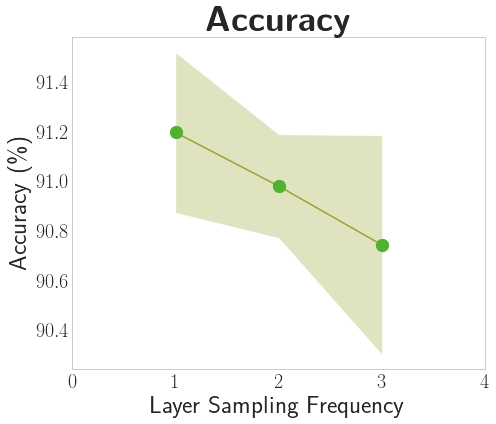

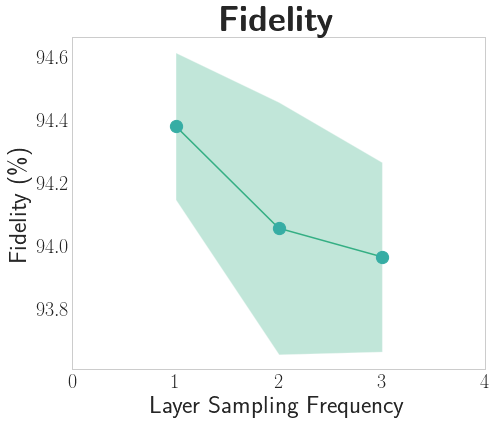

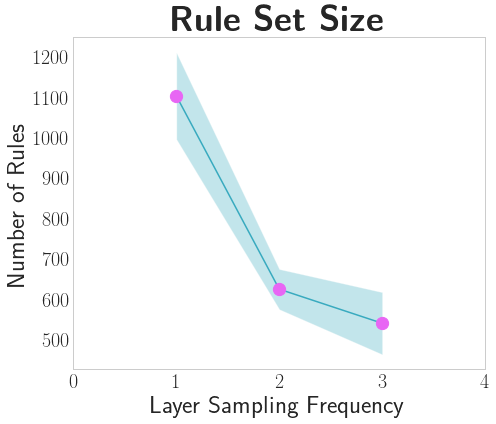

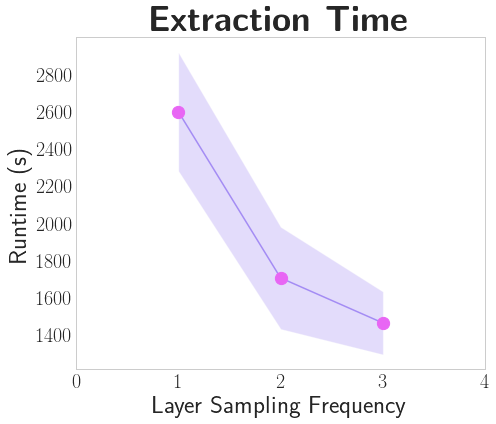

In [113]:
# Same as above but this time with MiniBooNE
fig, ax = plt.subplots(figsize=(7, 6))
clrs = sns.color_palette("husl", 12)
means = np.array(list(map(lambda x: x[0], miniboone_block_sizes_accuracies))) * 100
stds = np.array(list(map(lambda x: x[1], miniboone_block_sizes_accuracies))) * 100
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_block_sizes,
        means,
        label="Accuracy",
        c=clrs[3],
        zorder=1,
    )
    plt.scatter(miniboone_block_sizes, means, s=150, color=clrs[4], zorder=2)
    ax.fill_between(
        miniboone_block_sizes,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[3],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Layer Sampling Frequency", fontsize=25)
plt.ylabel("Accuracy (\%)", fontsize=25)
plt.title(r"$\textbf{Accuracy}$", fontsize=35)
plt.xticks([0, 1, 2, 3, 4], fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_hidden_layer_sampling_accuracy.png')
plt.show()


# Time to look at fidelity
fig, ax = plt.subplots(figsize=(7, 6))
means = np.array(list(map(lambda x: x[0], miniboone_block_sizes_fidelities))) * 100
stds = np.array(list(map(lambda x: x[1], miniboone_block_sizes_fidelities))) * 100
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_block_sizes,
        means,
        label="Fidelity",
        c=clrs[5],
        zorder=1,
    )
    plt.scatter(miniboone_block_sizes, means, s=150, color=clrs[6], zorder=2)
    ax.fill_between(
        miniboone_block_sizes,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[5],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Layer Sampling Frequency", fontsize=25)
plt.ylabel("Fidelity (\%)", fontsize=25)
plt.title(r"$\textbf{Fidelity}$", fontsize=35)
plt.xticks([0, 1, 2, 3, 4], fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_hidden_layer_sampling_fidelity.png')
plt.show()



# Rule set sizes
fig, ax = plt.subplots(figsize=(7, 6))
means = np.array(list(map(lambda x: x[0], miniboone_block_sizes_rule_sizes)))
stds = np.array(list(map(lambda x: x[1], miniboone_block_sizes_rule_sizes)))
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_block_sizes,
        means,
        label="Number of Rules",
        c=clrs[7],
        zorder=1,
    )
    plt.scatter(miniboone_block_sizes, means, s=150, color=clrs[10], zorder=2)
    ax.fill_between(
        miniboone_block_sizes,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[7],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Layer Sampling Frequency", fontsize=25)
plt.ylabel("Number of Rules", fontsize=25)
plt.title(r"$\textbf{Rule Set Size}$", fontsize=35)
plt.xticks([0, 1, 2, 3, 4], fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_hidden_layer_sampling_ruleset_size.png')
plt.show()


# Run times
fig, ax = plt.subplots(figsize=(7, 6))
means = np.array(list(map(lambda x: x[0], miniboone_block_sizes_runtimes)))
stds = np.array(list(map(lambda x: x[1], miniboone_block_sizes_runtimes)))
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_block_sizes,
        means,
        label="Runtime",
        c=clrs[9],
        zorder=1,
    )
    plt.scatter(miniboone_block_sizes, means, s=150, color=clrs[10], zorder=2)
    ax.fill_between(
        miniboone_block_sizes,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[9],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Layer Sampling Frequency", fontsize=25)
plt.ylabel("Runtime (s)", fontsize=25)
plt.title(r"$\textbf{Extraction Time}$", fontsize=35)
plt.xticks([0, 1, 2, 3, 4], fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_hidden_layer_sampling_runtime.png')
plt.show()

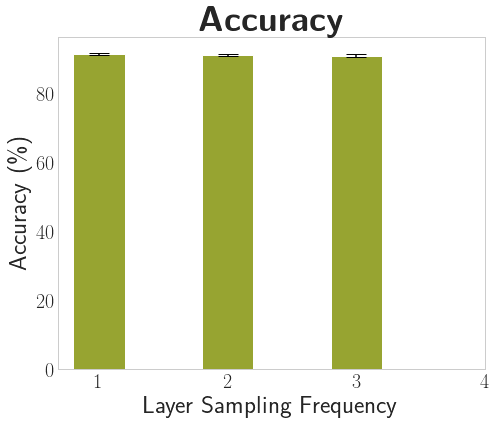

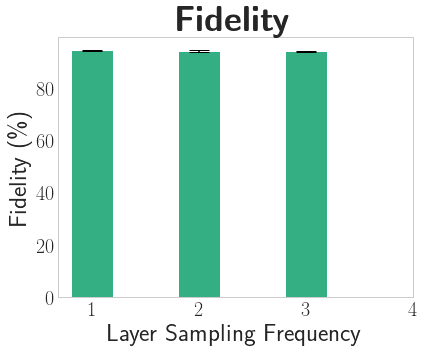

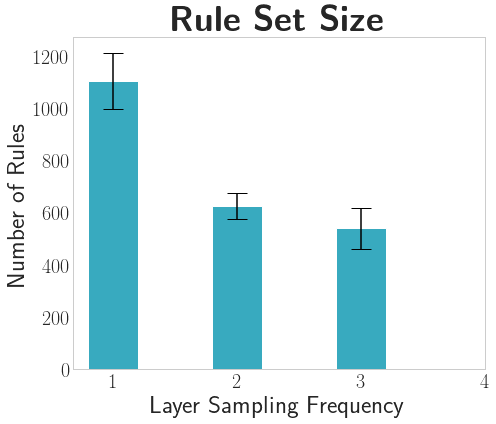

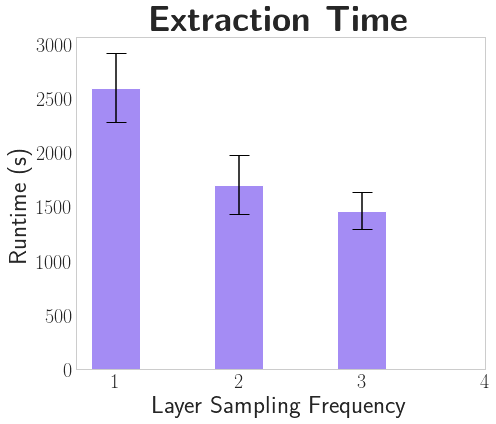

In [114]:

# Same as above but this time with MiniBooNE
fig, ax = plt.subplots(figsize=(7, 6))
clrs = sns.color_palette("husl", 12)
means = np.array(list(map(lambda x: x[0], miniboone_block_sizes_accuracies))) * 100
stds = np.array(list(map(lambda x: x[1], miniboone_block_sizes_accuracies))) * 100
with sns.axes_style("darkgrid"):
    ax.bar(
        miniboone_block_sizes,
        means,
        label="Accuracy",
        color=clrs[3],
        zorder=1,
        align='center',
        yerr=stds,
        capsize=10,
        width=0.4,
    )

# ax.legend(prop={"size":20})
plt.xlabel("Layer Sampling Frequency", fontsize=25)
plt.ylabel("Accuracy (\%)", fontsize=25)
plt.title(r"$\textbf{Accuracy}$", fontsize=35)
plt.xticks([1, 2, 3, 4], fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_hidden_layer_sampling_accuracy_bar.png')
plt.show()


# Time to look at fidelity
fig, ax = plt.subplots(figsize=(6, 5))
means = np.array(list(map(lambda x: x[0], miniboone_block_sizes_fidelities))) * 100
stds = np.array(list(map(lambda x: x[1], miniboone_block_sizes_fidelities))) * 100
with sns.axes_style("darkgrid"):
    ax.bar(
        miniboone_block_sizes,
        means,
        label="Fidelity",
        color=clrs[5],
        zorder=1,
        align='center',
        yerr=stds,
        capsize=10,
        width=0.4,
    )

    # ax.legend(prop={"size":20})
plt.xlabel("Layer Sampling Frequency", fontsize=25)
plt.ylabel("Fidelity (\%)", fontsize=25)
plt.title(r"$\textbf{Fidelity}$", fontsize=35)
plt.xticks([1, 2, 3, 4], fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_hidden_layer_sampling_fidelity_bar.png')
plt.show()



# Rule set sizes
fig, ax = plt.subplots(figsize=(7, 6))
means = np.array(list(map(lambda x: x[0], miniboone_block_sizes_rule_sizes)))
stds = np.array(list(map(lambda x: x[1], miniboone_block_sizes_rule_sizes)))
with sns.axes_style("darkgrid"):
    ax.bar(
        miniboone_block_sizes,
        means,
        label="Number of Rules",
        color=clrs[7],
        zorder=1,
        align='center',
        yerr=stds,
        capsize=10,
        width=0.4,
    )

# ax.legend(prop={"size":20})
plt.xlabel("Layer Sampling Frequency", fontsize=25)
plt.ylabel("Number of Rules", fontsize=25)
plt.title(r"$\textbf{Rule Set Size}$", fontsize=35)
plt.xticks([1, 2, 3, 4], fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_hidden_layer_sampling_ruleset_size_bar.png')
plt.show()


# Run times
fig, ax = plt.subplots(figsize=(7, 6))
means = np.array(list(map(lambda x: x[0], miniboone_block_sizes_runtimes)))
stds = np.array(list(map(lambda x: x[1], miniboone_block_sizes_runtimes)))
with sns.axes_style("darkgrid"):
    ax.bar(
        miniboone_block_sizes,
        means,
        label="Runtime",
        color=clrs[9],
        zorder=1,
        align='center',
        yerr=stds,
        capsize=10,
        width=0.4,
    )

# ax.legend(prop={"size":20})
plt.xlabel("Layer Sampling Frequency", fontsize=25)
plt.ylabel("Runtime (s)", fontsize=25)
plt.title(r"$\textbf{Extraction Time}$", fontsize=35)
plt.xticks([1, 2, 3, 4], fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_hidden_layer_sampling_runtime_bar.png')
plt.show()


# Data Subsampling for MAGIC experiment

In [64]:
# First let's extract the accuracies, rule sizes, and run times of all of our MAGIC experiments
magic_subsampling_results = extract_results('../results/MAGIC/dataset_size_ablation', 'erem_d_subsample_.*')
magic_subsampling_results.sort(key=lambda x: (x[1][0]['extractor_params']['max_number_of_samples'] or 1))
magic_subsampling_percents = list(map(lambda x: 100 * (x[1][0]['extractor_params']['max_number_of_samples'] or 1), magic_subsampling_results))
print(magic_subsampling_percents)
magic_subsampling_accuracies = list(map(lambda x: (np.mean(x[1][1]['re_acc']), np.std(x[1][1]['re_acc'])), magic_subsampling_results))
magic_subsampling_fidelities = list(map(lambda x: (np.mean(x[1][1]['re_fid']), np.std(x[1][1]['re_fid'])), magic_subsampling_results))
def _ruleset_sizes(rulesets):
    return list(map(
        lambda x: x.num_clauses(),
        rulesets
    ))

magic_subsampling_rule_sizes = list(map(
    lambda x: (np.mean(_ruleset_sizes(x[1][2])), np.std(_ruleset_sizes(x[1][2]))),
    magic_subsampling_results
))
magic_subsampling_runtimes = list(map(lambda x: (np.mean(x[1][1]['re_time (sec)']), np.std(x[1][1]['re_time (sec)'])), magic_subsampling_results))


[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100]


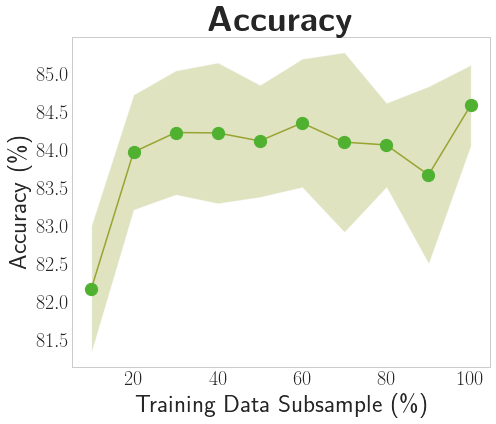

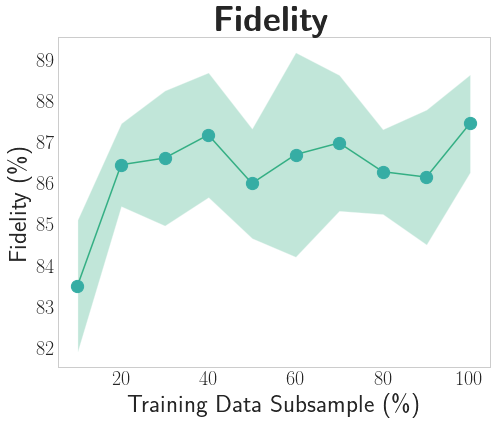

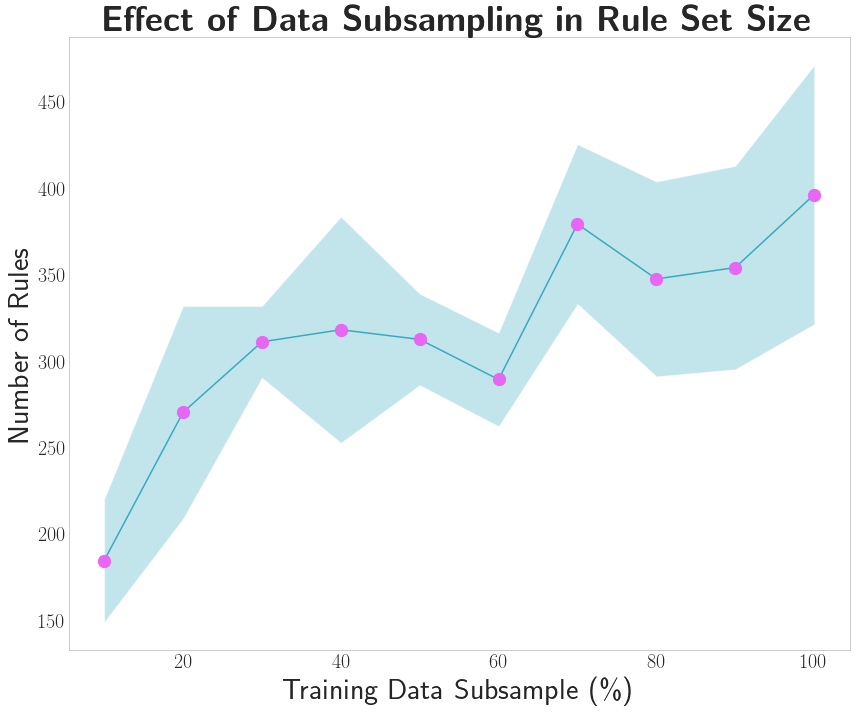

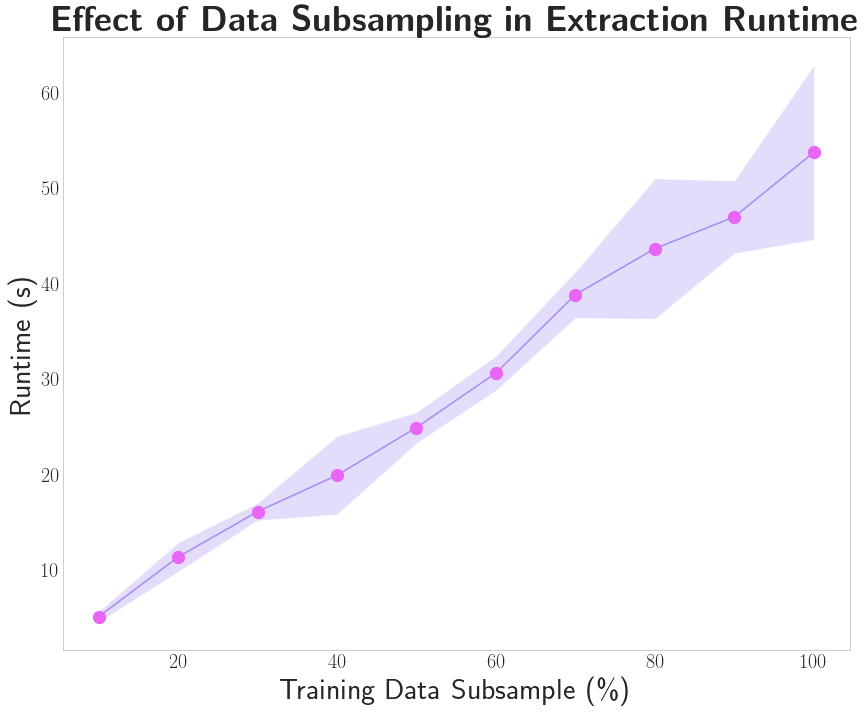

In [115]:

fig, ax = plt.subplots(figsize=(7, 6))
clrs = sns.color_palette("husl", 12)
means = np.array(list(map(lambda x: x[0], magic_subsampling_accuracies))) * 100
stds = np.array(list(map(lambda x: x[1], magic_subsampling_accuracies))) * 100
with sns.axes_style("darkgrid"):
    ax.plot(
        magic_subsampling_percents,
        means,
        label="Accuracy",
        c=clrs[3],
        zorder=1,
    )
    plt.scatter(magic_subsampling_percents, means, s=150, color=clrs[4], zorder=2)
    ax.fill_between(
        magic_subsampling_percents,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[3],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Training Data Subsample (\%)", fontsize=25)
plt.ylabel("Accuracy (\%)", fontsize=25)
plt.title(r"$\textbf{Accuracy}$", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_magic_data_subampling_accuracy.png')
plt.show()


# Time to look at fidelity
fig, ax = plt.subplots(figsize=(7, 6))
means = np.array(list(map(lambda x: x[0], magic_subsampling_fidelities))) * 100
stds = np.array(list(map(lambda x: x[1], magic_subsampling_fidelities))) * 100
with sns.axes_style("darkgrid"):
    ax.plot(
        magic_subsampling_percents,
        means,
        label="Fidelity",
        c=clrs[5],
        zorder=1,
    )
    plt.scatter(magic_subsampling_percents, means, s=150, color=clrs[6], zorder=2)
    ax.fill_between(
        magic_subsampling_percents,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[5],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Training Data Subsample (\%)", fontsize=25)
plt.ylabel("Fidelity (\%)", fontsize=25)
plt.title(r"$\textbf{Fidelity}$", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_magic_data_subampling_fidelity.png')
plt.show()



# Rule set sizes
fig, ax = plt.subplots(figsize=(12, 10))
means = np.array(list(map(lambda x: x[0], magic_subsampling_rule_sizes)))
stds = np.array(list(map(lambda x: x[1], magic_subsampling_rule_sizes)))
with sns.axes_style("darkgrid"):
    ax.plot(
        magic_subsampling_percents,
        means,
        label="Number of Rules",
        c=clrs[7],
        zorder=1,
    )
    plt.scatter(magic_subsampling_percents, means, s=150, color=clrs[10], zorder=2)
    ax.fill_between(
        magic_subsampling_percents,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[7],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Training Data Subsample (\%)", fontsize=30)
plt.ylabel("Number of Rules", fontsize=30)
plt.title(r"$\textbf{Effect of Data Subsampling in Rule Set Size}$", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_magic_data_subampling_ruleset_size.png')
plt.show()


# Run times
fig, ax = plt.subplots(figsize=(12, 10))
means = np.array(list(map(lambda x: x[0], magic_subsampling_runtimes)))
stds = np.array(list(map(lambda x: x[1], magic_subsampling_runtimes)))
with sns.axes_style("darkgrid"):
    ax.plot(
        magic_subsampling_percents,
        means,
        label="Runtime",
        c=clrs[9],
        zorder=1,
    )
    plt.scatter(magic_subsampling_percents, means, s=150, color=clrs[10], zorder=2)
    ax.fill_between(
        magic_subsampling_percents,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[9],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Training Data Subsample (\%)", fontsize=30)
plt.ylabel("Runtime (s)", fontsize=30)
plt.title(r"$\textbf{Effect of Data Subsampling in Extraction Runtime}$", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_magic_data_subampling_runtime.png')
plt.show()

# Data Subsampling for MiniBooNE experiment

In [65]:
# First let's extract the accuracies, rule sizes, and run times of all of our MiniBooNE experiments
miniboone_subsampling_results = extract_results('../results/MiniBooNE/sampling_ablation_study', 'erem_d_min_cases_0.001_max_samples_.*')
miniboone_subsampling_results.sort(key=lambda x: (x[1][0]['extractor_params']['max_number_of_samples'] or 1))
miniboone_subsampling_percents = list(map(lambda x: 100 * (x[1][0]['extractor_params']['max_number_of_samples'] or 1), miniboone_subsampling_results))
print(miniboone_subsampling_percents)
miniboone_subsampling_accuracies = list(map(lambda x: (np.mean(x[1][1]['re_acc']), np.std(x[1][1]['re_acc'])), miniboone_subsampling_results))
miniboone_subsampling_fidelities = list(map(lambda x: (np.mean(x[1][1]['re_fid']), np.std(x[1][1]['re_fid'])), miniboone_subsampling_results))
def _ruleset_sizes(rulesets):
    return list(map(
        lambda x: x.num_clauses(),
        rulesets
    ))

miniboone_subsampling_rule_sizes = list(map(
    lambda x: (np.mean(_ruleset_sizes(x[1][2])), np.std(_ruleset_sizes(x[1][2]))),
    miniboone_subsampling_results
))
miniboone_subsampling_runtimes = list(map(lambda x: (np.mean(x[1][1]['re_time (sec)']), np.std(x[1][1]['re_time (sec)'])), miniboone_subsampling_results))


[1.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100]


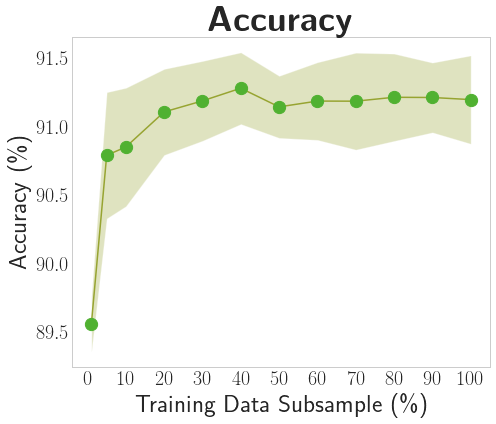

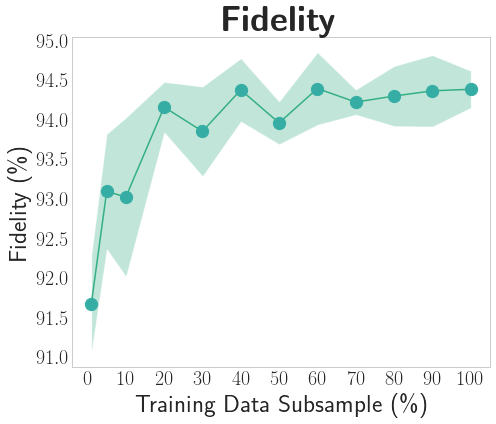

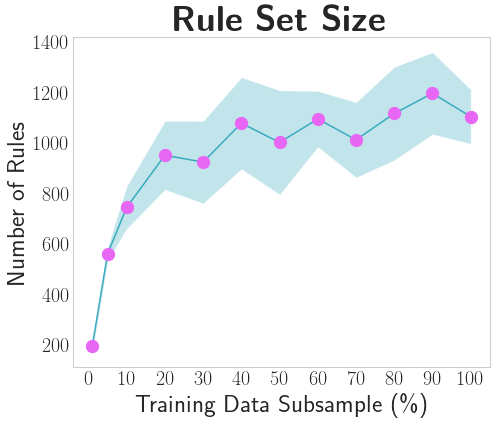

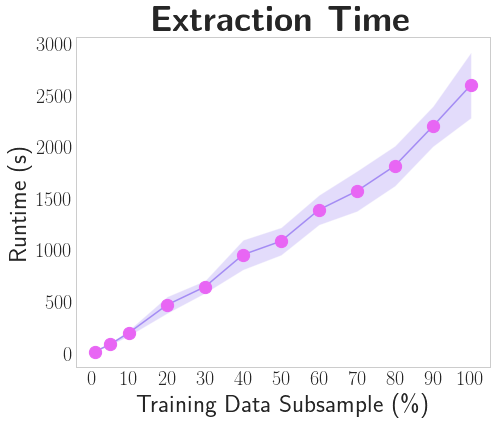

In [116]:

fig, ax = plt.subplots(figsize=(7, 6))
clrs = sns.color_palette("husl", 12)
means = np.array(list(map(lambda x: x[0], miniboone_subsampling_accuracies))) * 100
stds = np.array(list(map(lambda x: x[1], miniboone_subsampling_accuracies))) * 100
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_subsampling_percents,
        means,
        label="Accuracy",
        c=clrs[3],
        zorder=1,
    )
    plt.scatter(miniboone_subsampling_percents, means, s=150, color=clrs[4], zorder=2)
    ax.fill_between(
        miniboone_subsampling_percents,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[3],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Training Data Subsample (\%)", fontsize=25)
plt.ylabel("Accuracy (\%)", fontsize=25)
plt.title(r"$\textbf{Accuracy}$", fontsize=35)
plt.xticks(range(0, 110, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_data_subampling_accuracy.png')
plt.show()


# Time to look at fidelity
fig, ax = plt.subplots(figsize=(7, 6))
means = np.array(list(map(lambda x: x[0], miniboone_subsampling_fidelities))) * 100
stds = np.array(list(map(lambda x: x[1], miniboone_subsampling_fidelities))) * 100
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_subsampling_percents,
        means,
        label="Fidelity",
        c=clrs[5],
        zorder=1,
    )
    plt.scatter(miniboone_subsampling_percents, means, s=150, color=clrs[6], zorder=2)
    ax.fill_between(
        miniboone_subsampling_percents,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[5],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Training Data Subsample (\%)", fontsize=25)
plt.ylabel("Fidelity (\%)", fontsize=25)
plt.title(r"$\textbf{Fidelity}$", fontsize=35)
plt.xticks(range(0, 110, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_data_subampling_fidelity.png')
plt.show()



# Rule set sizes
fig, ax = plt.subplots(figsize=(7, 6))
means = np.array(list(map(lambda x: x[0], miniboone_subsampling_rule_sizes)))
stds = np.array(list(map(lambda x: x[1], miniboone_subsampling_rule_sizes)))
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_subsampling_percents,
        means,
        label="Number of Rules",
        c=clrs[7],
        zorder=1,
    )
    plt.scatter(miniboone_subsampling_percents, means, s=150, color=clrs[10], zorder=2)
    ax.fill_between(
        miniboone_subsampling_percents,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[7],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Training Data Subsample (\%)", fontsize=25)
plt.ylabel("Number of Rules", fontsize=25)
plt.title(r"$\textbf{Rule Set Size}$", fontsize=35)
plt.xticks(range(0, 110, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_data_subampling_ruleset_size.png')
plt.show()


# Run times
fig, ax = plt.subplots(figsize=(7, 6))
means = np.array(list(map(lambda x: x[0], miniboone_subsampling_runtimes)))
stds = np.array(list(map(lambda x: x[1], miniboone_subsampling_runtimes)))
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_subsampling_percents,
        means,
        label="Runtime",
        c=clrs[9],
        zorder=1,
    )
    plt.scatter(miniboone_subsampling_percents, means, s=150, color=clrs[10], zorder=2)
    ax.fill_between(
        miniboone_subsampling_percents,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[9],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Training Data Subsample (\%)", fontsize=25)
plt.ylabel("Runtime (s)", fontsize=25)
plt.title(r"$\textbf{Extraction Time}$", fontsize=35)
plt.xticks(range(0, 110, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_data_subampling_runtime.png')
plt.show()

# MiniBooNE Intermediate Rule Ranking

In [81]:
miniboone_ranking_results = extract_results('../results/MiniBooNE/rule_drop', 'erem_d_intermediate_drop_percent_.*')
miniboone_ranking_results.sort(key=lambda x: (x[1][0]['extractor_params']['intermediate_drop_percent']))
miniboone_ranking_percents = list(map(
    lambda x: 100 * (x[1][0]['extractor_params']['intermediate_drop_percent']),
    miniboone_ranking_results
))
print(miniboone_ranking_percents)
miniboone_ranking_accuracies = list(map(
    lambda x: (np.mean(x[1][1]['re_acc']), np.std(x[1][1]['re_acc'])),
    miniboone_ranking_results,
))
miniboone_ranking_fidelities = list(map(
    lambda x: (np.mean(x[1][1]['re_fid']), np.std(x[1][1]['re_fid'])),
    miniboone_ranking_results,
))
def _ruleset_sizes(rulesets):
    return list(map(
        lambda x: x.num_clauses(),
        rulesets
    ))

miniboone_ranking_rule_sizes = list(map(
    lambda x: (np.mean(_ruleset_sizes(x[1][2])), np.std(_ruleset_sizes(x[1][2]))),
    miniboone_ranking_results
))
miniboone_ranking_runtimes = list(map(
    lambda x: (np.mean(x[1][1]['re_time (sec)']), np.std(x[1][1]['re_time (sec)'])),
    miniboone_ranking_results,
))


[0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0]


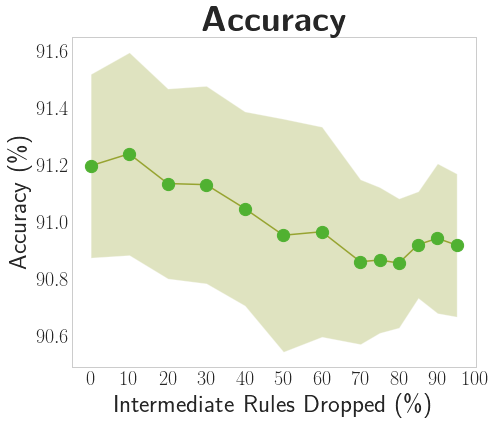

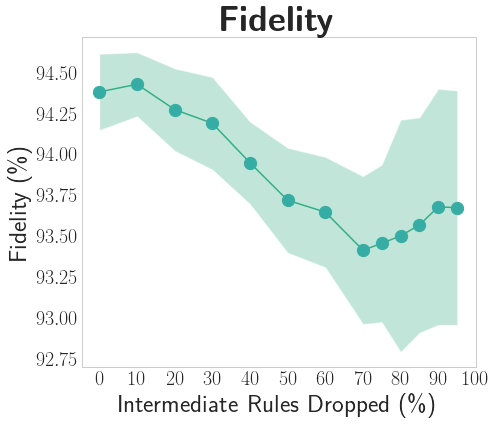

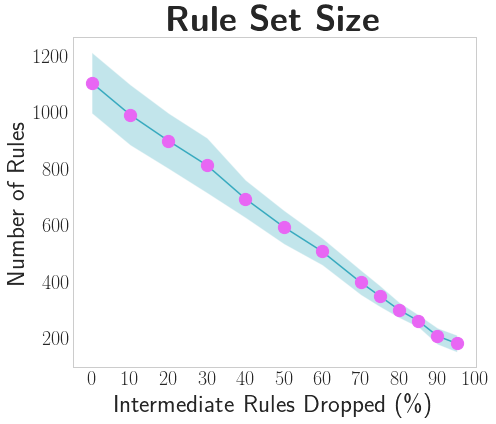

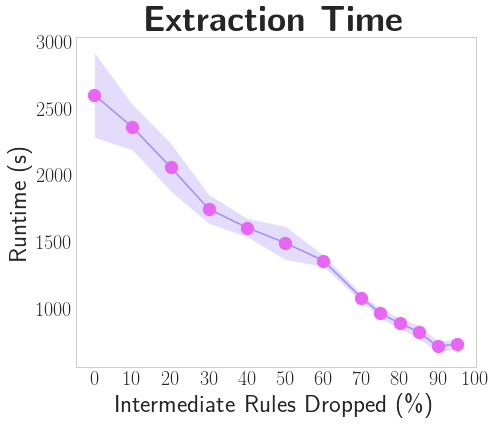

In [117]:

fig, ax = plt.subplots(figsize=(7, 6))
clrs = sns.color_palette("husl", 12)
means = np.array(list(map(lambda x: x[0], miniboone_ranking_accuracies))) * 100
stds = np.array(list(map(lambda x: x[1], miniboone_ranking_accuracies))) * 100
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_ranking_percents,
        means,
        label="Accuracy",
        c=clrs[3],
        zorder=1,
    )
    plt.scatter(miniboone_ranking_percents, means, s=150, color=clrs[4], zorder=2)
    ax.fill_between(
        miniboone_ranking_percents,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[3],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Intermediate Rules Dropped (\%)", fontsize=25)
plt.ylabel("Accuracy (\%)", fontsize=25)
plt.title(r"$\textbf{Accuracy}$", fontsize=35)
plt.xticks(range(0, 110, 10),fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_ranking_drop_accuracy.png')
plt.show()


# Time to look at fidelity
fig, ax = plt.subplots(figsize=(7, 6))
means = np.array(list(map(lambda x: x[0], miniboone_ranking_fidelities))) * 100
stds = np.array(list(map(lambda x: x[1], miniboone_ranking_fidelities))) * 100
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_ranking_percents,
        means,
        label="Fidelity",
        c=clrs[5],
        zorder=1,
    )
    plt.scatter(miniboone_ranking_percents, means, s=150, color=clrs[6], zorder=2)
    ax.fill_between(
        miniboone_ranking_percents,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[5],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Intermediate Rules Dropped (\%)", fontsize=25)
plt.ylabel("Fidelity (\%)", fontsize=25)
plt.title(r"$\textbf{Fidelity}$", fontsize=35)
plt.xticks(range(0, 110, 10),fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_ranking_drop_fidelity.png')
plt.show()



# Rule set sizes
fig, ax = plt.subplots(figsize=(7, 6))
means = np.array(list(map(lambda x: x[0], miniboone_ranking_rule_sizes)))
stds = np.array(list(map(lambda x: x[1], miniboone_ranking_rule_sizes)))
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_ranking_percents,
        means,
        label="Number of Rules",
        c=clrs[7],
        zorder=1,
    )
    plt.scatter(miniboone_ranking_percents, means, s=150, color=clrs[10], zorder=2)
    ax.fill_between(
        miniboone_ranking_percents,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[7],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Intermediate Rules Dropped (\%)", fontsize=25)
plt.ylabel("Number of Rules", fontsize=25)
plt.title(r"$\textbf{Rule Set Size}$", fontsize=35)
plt.xticks(range(0, 110, 10),fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_ranking_drop_ruleset_size.png')
plt.show()


# Run times
fig, ax = plt.subplots(figsize=(7, 6))
means = np.array(list(map(lambda x: x[0], miniboone_ranking_runtimes)))
stds = np.array(list(map(lambda x: x[1], miniboone_ranking_runtimes)))
with sns.axes_style("darkgrid"):
    ax.plot(
        miniboone_ranking_percents,
        means,
        label="Runtime",
        c=clrs[9],
        zorder=1,
    )
    plt.scatter(miniboone_ranking_percents, means, s=150, color=clrs[10], zorder=2)
    ax.fill_between(
        miniboone_ranking_percents,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=clrs[9],
    )

# ax.legend(prop={"size":20})
plt.xlabel("Intermediate Rules Dropped (\%)", fontsize=25)
plt.ylabel("Runtime (s)", fontsize=25)
plt.title(r"$\textbf{Extraction Time}$", fontsize=35)
plt.xticks(range(0, 110, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)
plt.tight_layout()
plt.savefig('../Dissertation/Figures/Chapter_3/eclaire_miniboone_ranking_drop_runtime.png')
plt.show()

In [219]:
letter_results = extract_results('../results/LetterRecognitionComplete', 'erem_d_balance_min_cases_.*')


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [232]:
letter_results.sort(key=lambda x: np.mean(x[1][1]['re_acc']))
print("mu =", letter_results[-1][1][0]['extractor_params']['min_cases'])
print("Accuracy:", np.mean(letter_results[-1][1][1]['re_acc']), np.std(letter_results[-1][1][1]['re_acc']))
print("Fidelity:", np.mean(letter_results[-1][1][1]['re_fid']), np.std(letter_results[-1][1][1]['re_fid']))
print("Runtime:", np.mean(letter_results[-1][1][1]['re_time (sec)']), np.std(letter_results[-1][1][1]['re_time (sec)']))
print("Memory:", np.mean(letter_results[-1][1][1]['re_memory (MB)']), np.std(letter_results[-1][1][1]['re_memory (MB)']))
print("Rule set size:", np.mean(_ruleset_sizes(letter_results[-1][1][2])), np.std(_ruleset_sizes(letter_results[-1][1][2])))
letter_results[-1][1][1]
print(list(map(lambda x: x[1][0]['extractor_params']['min_cases'], letter_results)))

mu = 8
Accuracy: 0.55695 0.04337061216999367
Fidelity: 0.5569 0.043373551849024305
Runtime: 473.17928924560545 7.830118877891513
Memory: 2802.0414464 165.92451304612032
Rule set size: 1219.4 70.6444619202383
[14, 65, 19, 50, 5, 85, 7, 25, 75, 80, 100, 18, 90, 70, 4, 40, 55, 60, 13, 45, 11, 95, 20, 35, 6, 16, 12, 15, 9, 17, 30, 10, 8]


In [90]:
l = [1166, 1947, 984, 4191, 878]
np.mean(l), np.std(l)

(1833.2, 1237.0024090518175)